In [1]:
#Data Collection

#Api extraction from arXiv for a Co-authorship Network

import requests  # Import the requests library to make HTTP requests.
import xml.etree.ElementTree as ET  # Import the ElementTree library for XML parsing.
import csv  # Import the csv library for reading/writing CSV files.

# Function to fetch data from the arXiv API and save it to CSV files.
def fetch_and_save_to_csv():
    nodes = set()  # Initialize an empty set for nodes (unique authors).
    edges = set()  # Initialize an empty set for edges (unique author collaborations).

    # Define the base URL for the arXiv API and query parameters.
    ARXIV_API_URL = "http://export.arxiv.org/api/query?"
    search_query = "cat:cs.LG"  # Search query parameter (category: Computer Science - Machine Learning).
    start = 0  # Starting index for fetching results.
    max_results = 250  # Maximum number of results to fetch.

    # Bundle the query parameters into a dictionary.
    query_params = {
        "search_query": search_query,
        "start": start,
        "max_results": max_results
    }

    # Make a GET request to the arXiv API with the specified query parameters.
    response = requests.get(ARXIV_API_URL, params=query_params)
    # Check if the request was successful (HTTP status code 200).
    if response.status_code == 200:
        # Parse the XML content of the response.
        root = ET.fromstring(response.content)
        # Define the namespace to handle the XML namespace used by the arXiv feed.
        ns = {'atom': 'http://www.w3.org/2005/Atom'}

        # Iterate over each entry (paper) in the feed.
        for entry in root.findall('atom:entry', ns):
            # Find all author names for the current entry.
            authors = entry.findall('atom:author/atom:name', ns)
            # Extract the text content (author names) from the author elements.
            author_names = [author.text for author in authors]

            # Add each author name to the nodes set (ensuring uniqueness).
            for author in author_names:
                nodes.add(author)
            # Create unique pairs of authors (collaborations) and add them to the edges set.
            for i in range(len(author_names)):
                for j in range(i + 1, len(author_names)):
                    edges.add((author_names[i], author_names[j]))

    # Save the nodes data to a CSV file.
    with open('nodes.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Id", "Label"])  # Write the header row for the nodes CSV.
        # Write each node (author name) to the CSV file.
        for node in nodes:
            writer.writerow([node, node])  # Using author name as both ID and Label.

    # Save the edges data to a CSV file.
    with open('edges.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Source", "Target"])  # Write the header row for the edges CSV.
        # Write each edge (collaborataion) to the CSV file.
        for edge in edges:
            writer.writerow([edge[0], edge[1]])  # Source and Target of the collaboration.

    # Print a confirmation message once data is successfully saved to CSV files.
    print("Data saved to CSV.")

# Call the function to perform the fetch and save operation.
fetch_and_save_to_csv()

Data saved to CSV.


In [2]:
#Data Cleaning
#The code removes duplicate entries and converts each name to a Title format e.g john doe to John Doe 
#Also trailing white spaces are removed

import pandas as pd

# Load the edge csv file
df_edge= pd.read_csv('edges.csv',encoding='utf-8')

# Load the node csv file
df_node= pd.read_csv('nodes.csv',encoding='utf-8')

# Remove duplicate rows
df_edge.drop_duplicates(subset=['Source', 'Target'], keep='first', inplace=True)
df_node.drop_duplicates(subset=['Label'], keep='first', inplace=True)


#Convert to title 
df_edge['Source'] = df_edge['Source'].str.strip().str.title()
df_edge['Target'] = df_edge['Target'].str.strip().str.title()

df_node['Label'] = df_node['Label'].str.strip().str.title()


# Save the result to a new CSV file
df_edge.to_csv('edges_cleaned.csv', index=False)
df_node.to_csv('nodes_cleaned.csv', index=False)


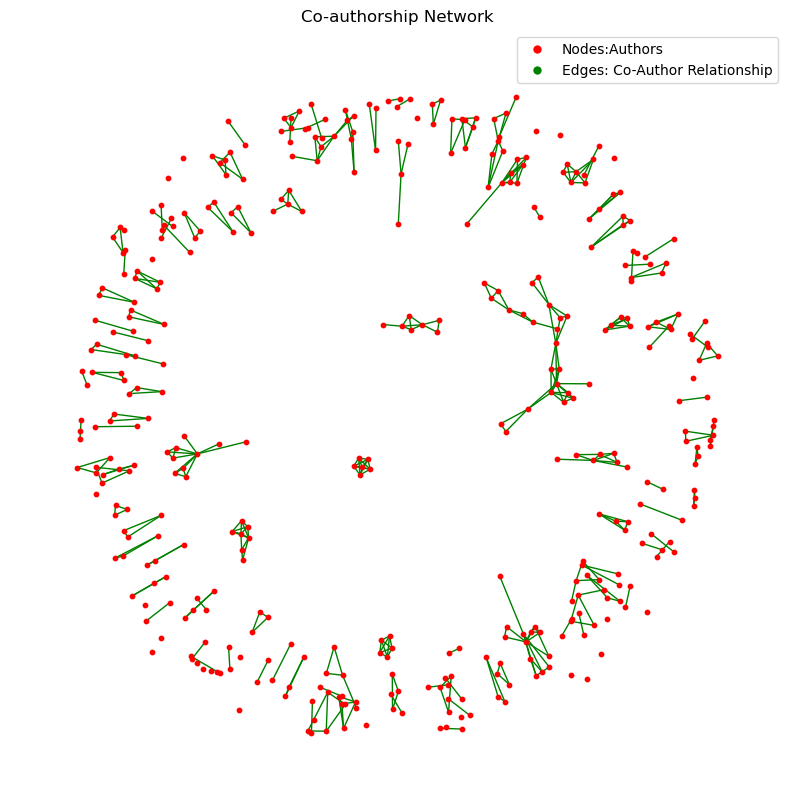

In [3]:
#Data visualization
import pandas as pd
    # Paths to the CSV files
nodes_path = 'nodes_cleaned.csv'
edges_path = 'edges_cleaned.csv'
    # Load the data
nodes_df = pd.read_csv(nodes_path)
edges_df = pd.read_csv(edges_path)
import networkx as nx
# Initialize an empty graph
G = nx.Graph()
# Add Nodes
for index, row in nodes_df.iterrows():
    G.add_node(row['Label'])   
# Add edges
for index, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'])
import matplotlib.pyplot as plt
# Draw the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G,seed=42,k=0.12,scale=0.2)
nx.draw_networkx_nodes(G, pos, node_size=10, alpha=1,node_color="red")
nx.draw_networkx_edges(G, pos, width=1, alpha=1,edge_color="green")
    # Create a legend
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Nodes:Authors',markersize=7, markerfacecolor='red')
green_patch = plt.Line2D([0], [0], marker='o', color='w', label='Edges: Co-Author Relationship',markersize=7, markerfacecolor='green')
# Add the legend to the plot
plt.legend(handles=[red_patch, green_patch])
plt.title('Co-authorship Network')
plt.axis('off')
plt.show()

In [4]:
import pandas as pd
import networkx as nx

# File paths
nodes_csv_file = r'nodes_cleaned.csv'
edges_csv_file = r'edges_cleaned.csv'
output_csv_file = r'degree_edges.csv'

# Read nodes.csv and edges.csv files
nodes_df = pd.read_csv(nodes_csv_file)
edges_df = pd.read_csv(edges_csv_file)

# Create a graph from the edges data
G = nx.from_pandas_edgelist(edges_df, 'Source', 'Target')

# Calculate degree distribution for nodes
degree_distribution = dict(nx.degree(G))

# Update nodes DataFrame with degree information
nodes_df['Degree'] = nodes_df['Id'].map(degree_distribution).fillna(0).astype(int)

# Write the updated nodes DataFrame back to the nodes_cleaned.csv file
nodes_df.to_csv(nodes_csv_file, index=False)

print("Degree distribution for nodes has been calculated and stored in", nodes_csv_file)


Degree distribution for nodes has been calculated and stored in nodes_cleaned.csv


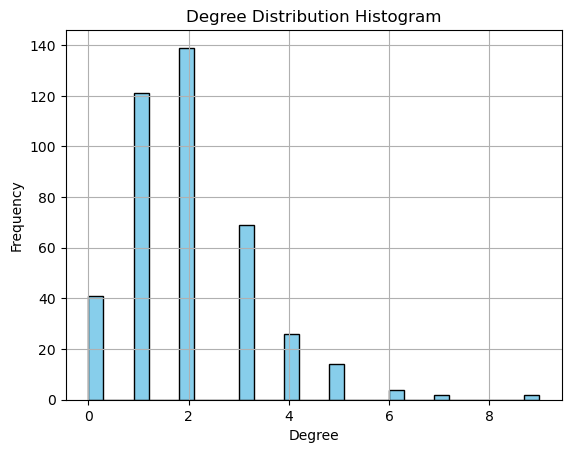

In [5]:
#histogram plot for Degree_distribution
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
csv_file_path = r'nodes_cleaned.csv'
df = pd.read_csv(csv_file_path)

# Assuming the CSV file has a column named 'Degree' containing the degree distribution
# Extract the degree column
degrees = df['Degree']

# Plot the histogram
plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
plt.title('Degree Distribution Histogram')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
import pandas as pd
import networkx as nx

# File paths
nodes_csv_file = r'nodes_cleaned.csv'
edges_csv_file = r'edges_cleaned.csv'

# Read nodes.csv and edges.csv files
nodes_df = pd.read_csv(nodes_csv_file)
edges_df = pd.read_csv(edges_csv_file)

# Create a graph from the edges data
G = nx.from_pandas_edgelist(edges_df, 'Source', 'Target')

# Calculate clustering coefficients for all nodes
clustering_coefficients = nx.clustering(G)

# Update nodes DataFrame with clustering coefficient information
nodes_df['Clustering_Coefficient'] = nodes_df['Id'].map(clustering_coefficients).fillna(0)

# Write the updated nodes DataFrame back to the nodes.csv file
nodes_df.to_csv(nodes_csv_file, index=False)

print("Clustering coefficients for nodes have been calculated and stored in", nodes_csv_file)


Clustering coefficients for nodes have been calculated and stored in nodes_cleaned.csv


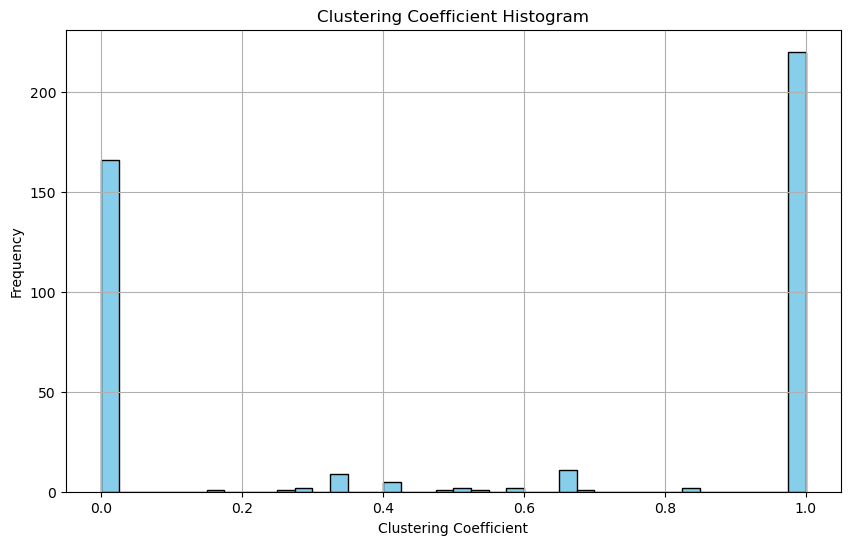

In [8]:
#histogram plot for clustering_coefficient
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file containing the clustering coefficient data
csv_file_path = r'nodes_cleaned.csv'  # Update with your file path

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Extract the clustering coefficient column
clustering_coefficients = df['Clustering_Coefficient']
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(clustering_coefficients, bins=40, color='skyblue', edgecolor='black')
plt.title('Clustering Coefficient Histogram')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [7]:
import pandas as pd
import networkx as nx

# File paths
nodes_csv_file = r'nodes_cleaned.csv'
edges_csv_file = r'edges_cleaned.csv'

# Read nodes.csv and edges.csv files
nodes_df = pd.read_csv(nodes_csv_file)
edges_df = pd.read_csv(edges_csv_file)

# Create a directed graph from the edges data
G = nx.DiGraph()
G.add_edges_from(zip(edges_df['Source'], edges_df['Target']))

# Calculate PageRank for each node
pagerank_values = nx.pagerank(G)

# Update nodes DataFrame with PageRank information
nodes_df['PageRank'] = nodes_df['Id'].map(pagerank_values).fillna(0)

# Write the updated nodes DataFrame back to the nodes.csv file
nodes_df.to_csv(nodes_csv_file, index=False)

print("PageRank values for nodes have been calculated and stored in", nodes_csv_file)


PageRank values for nodes have been calculated and stored in nodes_cleaned.csv


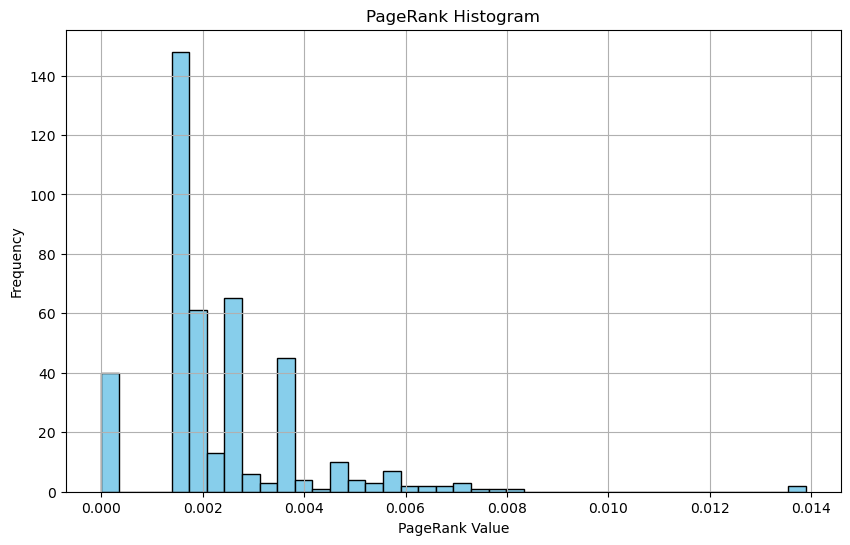

In [7]:
#histogram plot for pageRank of nodes
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file containing the PageRank values
# Update with your file path
csv_file_path = r'nodes_cleaned.csv'  

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Extract the PageRank column
pagerank_values = df['PageRank']

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(pagerank_values, bins=40, color='skyblue', edgecolor='black')
plt.title('PageRank Histogram')
plt.xlabel('PageRank Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()